In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from settings import colors as nc_colors
from settings import ax_label_size, tick_label_size, letter_size
import mpl_lego.style as style
import mpl_lego as mplego
from mpl_lego.ellipse import plot_cov_ellipse

import neuropacks as packs
from noise_correlations.utils import angle2R
from noise_correlations.discriminability import lfi

%matplotlib inline

In [2]:
ccycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
mu_scatter_size = 20

# RET2 path
data_path = '/storage/data_from_mathew/200114_fov1_data.mat'
# Create neuropack
pack = packs.RET2(data_path=data_path)
X_ret2 = pack.get_response_matrix(cells='tuned', response='max')
# Extract stimuli
stimuli_ret2 = pack.angles
unique_stimuli_ret2 = pack.unique_angles
stim1 = 0
stim2 = 60
neuron1 = 32
neuron2 = 25
X1 = X_ret2[stimuli_ret2 == stim1][:, [neuron1, neuron2]]
mu1 = np.mean(X1, axis=0)
X2 = X_ret2[stimuli_ret2 == stim2][:, [neuron1, neuron2]]
mu2 = np.mean(X2, axis=0)

In [4]:
center = 1 / np.sqrt([2, 2])
base = np.array([[0.50, 0.25],
                 [0.25, 0.30]])

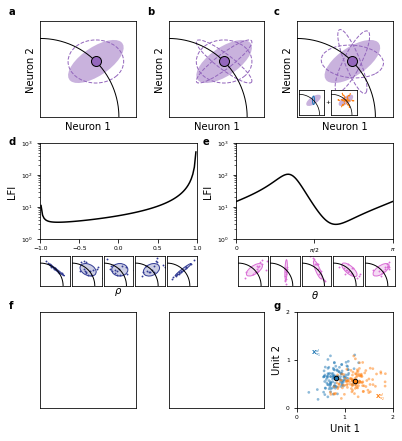

In [5]:
fig_x = 5.5
fig_y = 6
figsize = (fig_x, fig_y)
fig = plt.figure(figsize=figsize)

le = .1
re = .01
te = .015
be = .07
bhg = .1
shg = bhg / 20.
vg = .06
svg = .04
w2 = (1. - le - re - bhg) / 2.
sw = (1. - le - re - bhg - 8. * shg) / 10.
sh = sw * figsize[0] / figsize[1]
bh = (1. - be - te - 3*vg - sh) / 3.
w3 = bh * figsize[1] / figsize[0]
hg3 = (1. - le - re - 3*w3) / 2.

y = be
axes_bottom = [fig.add_axes([le + (w3 + hg3)*ii, y, w3, bh]) for ii in range(3)]
y += bh + vg
saxes = ([fig.add_axes([le + ii*(sw + shg), y, sw, sh]) for ii in range(5)]
         + [fig.add_axes([le + bhg + (5 + ii)*(sw + shg), y, sw, sh]) for ii in range(5)])
y += sh + svg
axes_mid = [fig.add_axes([le + (w2 + bhg)*ii, y, w2, bh]) for ii in range(2)]
y += bh + vg
axes_top = [fig.add_axes([le + (w3 + hg3)*ii, y, w3, bh]) for ii in range(3)]

n1 = np.linspace(0, 1, 1000)
n2 = np.sqrt(1 - n1**2)
dash_lw = 1

# Plot shuffle null model
shuffleax = axes_top[0]
shuffle = np.diag(np.diag(base))
plot_cov_ellipse(shuffle,
                 mu=center,
                 ax=shuffleax,
                 facecolor=mplego.colors.hex_to_rgb(ccycle[4], 0.0),
                 edgecolor=mplego.colors.hex_to_rgb(ccycle[4], 1.0),
                 n_std=0.5,
                 linewidth=dash_lw,
                 linestyle='--',
                 include_mu=False)

# Plot ucorr null model
shuffleax = axes_top[1]
sigma = np.sqrt(np.diag(base))
corrs = [-.9, 0, .9]
for c in corrs:
    mat = np.eye(2)
    mat[0, 1] = c
    mat[1, 0] = c
    ucorr = mat * np.outer(sigma, sigma)
    plot_cov_ellipse(ucorr,
                     mu=center,
                     ax=shuffleax,
                     facecolor=mplego.colors.hex_to_rgb(ccycle[4], 0.0),
                     edgecolor=mplego.colors.hex_to_rgb(ccycle[4], 1.0),
                     n_std=0.5,
                     linewidth=dash_lw,
                     linestyle='--',
                     include_mu=False)

# Plot factor analysis null model
faax = axes_top[2]
v = np.array([0.70, (0.25 / 0.70)])
shared = np.outer(v, v)
private = base - shared

# Rotate the latent shared variability
angle1 = 30
angle2 = -30
angle3 = 90
R1 = angle2R(angle1)
R2 = angle2R(angle2)
R3 = angle2R(angle3)
rot1 = private + R1 @ shared @ R1.T
rot2 = private + R2 @ shared @ R2.T
rot3 = private + R3 @ shared @ R3.T

# Plot three rotations
for rot in [rot1, rot2, rot3]:
    plot_cov_ellipse(rot,
                     mu=center,
                     ax=faax,
                     facecolor=mplego.colors.hex_to_rgb(ccycle[4], 0.0),
                     edgecolor=mplego.colors.hex_to_rgb(ccycle[4], 1.0),
                     n_std=0.5,
                     linewidth=dash_lw,
                     linestyle='--',
                     include_mu=False)

start_x = faax.get_position().xmin + (.005 * fig_y / fig_x)
start_y = faax.get_position().ymin + .005
size = .35
dx = .1
inset0 = fig.add_axes([start_x, start_y, size / fig_x, size / fig_y])
inset1 = fig.add_axes([start_x + (size + dx) / fig_x, start_y, size / fig_x, size / fig_y])
fig.text(start_x + (2*size + dx) / fig_x / 2, start_y + size / fig_y / 2. + .00,
         '+', size=tick_label_size, va='center', ha='center')
plot_cov_ellipse(base,
                 mu=center,
                 ax=inset0,
                 facecolor=mplego.colors.hex_to_rgb(ccycle[4], 0.5),
                 n_std=0.5,
                 include_mu=False)
plot_cov_ellipse(base,
                 mu=center,# + np.array([dx, 0]),
                 ax=inset1,
                 facecolor=mplego.colors.hex_to_rgb(ccycle[4], 0.5),
                 n_std=0.5,
                 include_mu=False)
# Rotate the latent shared variability
rot1 = np.diag(0.003 * np.ones(2)) + R1 @ shared @ R1.T
rot2 = np.diag(0.003 * np.ones(2)) + R2 @ shared @ R2.T
rot3 = np.diag(0.003 * np.ones(2)) + R3 @ shared @ R3.T
# Plot three rotations
for rot in [rot1, rot2, rot3]:
    plot_cov_ellipse(rot,
                     mu=center,# + np.array([dx, 0]),
                     ax=inset1,
                     facecolor=mplego.colors.hex_to_rgb(ccycle[1], 0.0),
                     edgecolor=mplego.colors.hex_to_rgb(ccycle[1], 1.0),
                     n_std=0.5,
                     linewidth=1.,
                     linestyle='--',
                     include_mu=False)
# Plot private covariance ellipse
plot_cov_ellipse(private,
                 mu=center,
                 ax=inset0,
                 facecolor='None',
                 edgecolor=mplego.colors.hex_to_rgb(ccycle[0], 1.0),
                 n_std=0.5,
                 linewidth=1.,
                 linestyle='-',
                 include_mu=False)
for ax in [inset0, inset1]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0., 1.22])
    ax.set_ylim([0., 1.22])
    ax.plot(n1, n2,
            color='black',
            linewidth=.75)

# Middle row
df = np.array([-1., 1.])

sigma = np.sqrt(np.diag(base))
corrs = np.linspace(-.99, .99, 101)
u_lfis = np.zeros_like(corrs)
for ii, c in enumerate(corrs):
    mat = np.eye(2)
    mat[0, 1] = c
    mat[1, 0] = c
    ucorr = mat * np.outer(sigma, sigma)
    u_lfis[ii] = df @ np.linalg.lstsq(ucorr, df, rcond=None)[0]

thetas = np.linspace(0., np.pi, 100)
fa_lfis = np.zeros_like(thetas)
v = np.array([0.70, (0.25 / 0.70)])
shared = np.outer(v, v)
private = base - shared

for ii, th in enumerate(thetas):
    R = np.array([[np.cos(th), np.sin(th)], [-np.sin(th), np.cos(th)]])
    fa_cov = private + R.T @ shared @ R
    fa_lfis[ii] = df @ np.linalg.lstsq(fa_cov, df, rcond=None)[0]
ax = axes_mid[0]
ax.plot(corrs, u_lfis, c='k')
ax.set_xlabel(r'$\rho$', size=ax_label_size, labelpad=35)
ax.set_ylabel(r'LFI', size=ax_label_size)
ax.set_yscale('log')

ax = axes_mid[1]
ax.plot(thetas, fa_lfis, c='k')
ax.set_xlabel(r'$\theta$', size=ax_label_size, labelpad=35)
ax.set_ylabel(r'LFI', size=ax_label_size)
ax.set_yscale('log')

idxs = [0, 33, 50, 66, 99]
for ii in range(5):
    idx = idxs[ii]
    mat = np.eye(2)
    mat[0, 1] = corrs[idx]
    mat[1, 0] = corrs[idx]
    ucorr = mat * np.outer(sigma, sigma)
    plot_cov_ellipse(ucorr,
                 mu=center,
                 ax=saxes[ii],
                 facecolor=mplego.colors.hex_to_rgb(nc_colors['uniform'], 0.25),
                 edgecolor=mplego.colors.hex_to_rgb(nc_colors['uniform'], 1.0),
                 n_std=.5,
                 linewidth=1.,
                 linestyle='-',
                 include_mu=False)
    x, y = np.random.multivariate_normal(center, ucorr / 8., size=15).T
    saxes[ii].scatter(x, y, marker='.', c=nc_colors['uniform'], s=3)
    
    th = thetas[idx]
    R = np.array([[np.cos(th), np.sin(th)], [-np.sin(th), np.cos(th)]])
    fa_cov = private + R.T @ shared @ R
    plot_cov_ellipse(fa_cov,
                 mu=center,
                 ax=saxes[ii+5],
                 facecolor=colors.to_rgba(nc_colors['fa'], 0.25),
                 edgecolor=colors.to_rgba(nc_colors['fa'], 1.0),
                 n_std=0.5,
                 linewidth=1.,
                 linestyle='-',
                 include_mu=False)
    x, y = np.random.multivariate_normal(center, fa_cov / 8., size=15).T
    saxes[ii+5].scatter(x, y, marker='.', c=nc_colors['fa'], s=3)

axes_mid[0].set_xlim(-1, 1)
axes_mid[0].set_xticks([-1, -.5, 0, .5, 1])
axes_mid[1].set_xlim(0, np.pi)
axes_mid[1].set_xticks([0, np.pi/2, np.pi])
axes_mid[1].set_xticklabels([0, r'$\pi/2$', r'$\pi$'])
for ax in axes_mid:
    ax.set_ylim(1, 1e3)
for ax in saxes:
    ax.plot(n1, n2,
        color='black',
        linewidth=1)
    ax.set_xlim([0., 1.3])
    ax.set_ylim([0., 1.3])
    ax.set_xticks([])
    ax.set_yticks([])

# Bottom row
ax = axes_bottom[2]
ax.scatter(
    X1[:, 0],
    X1[:, 1],
    marker='.',
    s=30,
    color='C0',
    edgecolor='none',
    alpha=0.50)
ax.scatter(
    X2[:, 0],
    X2[:, 1],
    marker='.',
    s=30,
    color='C1',
    edgecolor='none',
    alpha=0.50)
ax.scatter(
    mu1[0], mu1[1],
    color='C0',
    s=mu_scatter_size,
    edgecolor='black')
ax.scatter(
    mu2[0], mu2[1],
    color='C1',
    s=mu_scatter_size,
    edgecolor='black')

ax.text(
    x=0.4, y=1.15, s=r'$\mathbf{X}_{s_1}^d$',
    va='center',
    ha='center',
    color='C0',
    size=tick_label_size)
ax.text(
    x=1.75, y=0.23, s=r'$\mathbf{X}_{s_2}^d$',
    va='center',
    ha='center',
    color='C1',
    size=tick_label_size)

ax.set_xlim([0., 2])
ax.set_ylim(ax.get_xlim())
ax.set_xticks([0, 1, 2])
ax.set_yticks(ax.get_xticks())
ax.set_xlabel(r'Unit 1', fontsize=ax_label_size)
ax.set_ylabel(r'Unit 2', fontsize=ax_label_size)




for ax in axes_top + axes_bottom[:-1]:
    ax.set_xticks([])
    ax.set_yticks([])

    
for ax in axes_top:
    ax.plot(n1, n2,
        color='black',
        linewidth=1)
    ax.set_xlim([0, 1.22])
    ax.set_ylim([0, 1.22])
        
    # Axes labels
    ax.set_xlabel(r'Neuron 1',
                  fontsize=ax_label_size,
                  labelpad=4)
    ax.set_ylabel(r'Neuron 2',
              fontsize=ax_label_size,
              labelpad=4)
    plot_cov_ellipse(base,
                     mu=center,
                     ax=ax,
                     facecolor=mplego.colors.hex_to_rgb(ccycle[4], 0.5),
                     n_std=0.5,
                     include_mu=False)
    ax.scatter(center[0],
               center[1],
               color=ccycle[4],
               edgecolor='black',
               s=100,
               zorder=1000)


xs = [.02, .37, .69]
ys = [.98, .3]
fig.text(xs[0], .68, 'd',
         size=letter_size,
         fontweight='bold')
fig.text(.51, .68, 'e',
         size=letter_size,
         fontweight='bold')
lets = ['a', 'b', 'c', 'f', '', 'g']
c = 0
for ii in range(2):
    for jj in range(3):
        fig.text(xs[jj], ys[ii], lets[c],
                 size=letter_size,
                 fontweight='bold')
        c += 1
for ax in axes_top + axes_mid + axes_bottom:
    ax.tick_params(labelsize=tick_label_size)

plt.savefig('figure2.pdf', dpi=300)
plt.savefig('figure2.jpg', dpi=300)